In [2]:
import pandas as pd

sex_dict={'I':0,'M':1,'F':2}
def sex_map(sex):
    return sex_dict[sex]
names=['性别','长度','直径','高度','总重量','皮重','内脏重量','克重','年龄']
df=pd.read_csv('./data/data361/AbaloneAgePrediction.txt',names=names,converters={'性别':sex_map})
df.head(3)

,性别,长度,直径,高度,总重量,皮重,内脏重量,克重,年龄
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


In [4]:
df=(df-df.min())/(df.max()-df.min())
df.head(3)


,性别,长度,直径,高度,总重量,皮重,内脏重量,克重,年龄
0,0.5,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0.500000
1,0.5,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0.214286
2,1.0,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,0.285714


In [6]:
from sklearn.model_selection import train_test_split
train_data,eval_data=train_test_split(df,test_size=0.1,random_state=42)
train_data.head(3)

,性别,长度,直径,高度,总重量,皮重,内脏重量,克重,年龄
3789,1.0,0.770270,0.764706,0.137168,0.399150,0.336584,0.315339,0.339312,0.321429
1370,0.5,0.729730,0.697479,0.146018,0.398796,0.299597,0.288348,0.337319,0.321429
2384,1.0,0.493243,0.487395,0.092920,0.151054,0.110289,0.108624,0.130045,0.357143


In [33]:
import paddle

def custom_reader(data):
    def reader():
        for x in data.values:
           yield [x[:-1],x[-1:]]
    return reader
batch_size=16
train_reader=paddle.batch(custom_reader(train_data),batch_size=batch_size)
eval_reader=paddle.batch(custom_reader(eval_data),batch_size=batch_size)

In [31]:
count=0
for x in train_data.values:
    count+=1
    if count>2:break
    print(x)

[1.         0.77027027 0.76470588 0.13716814 0.39914999 0.33658373
 0.31533904 0.33931241 0.32142857]
[0.5        0.72972973 0.69747899 0.1460177  0.39879582 0.2995965
 0.2883476  0.33731938 0.32142857]


In [36]:
for batch_id,data in enumerate(train_reader()):
    if(batch_id<5):
       print(batch_id)
       #print(data) #按批过来了16个
       d_x=[x[0] for x in data]
       d_y=[x[1] for x in data]
       print(d_x[0][0])


0
1.0
1
1.0
2
0.0
3
1.0
4
0.5


In [39]:
import paddle.fluid as fluid
class Regressor(fluid.dygraph.Layer):
    def __init__(self,name_scope):
        super(Regressor,self).__init__(name_scope)
        name_scope=self.full_name()
        self.fc=fluid.Linear(input_dim=8,output_dim=1)

    def forward(self,inputs):
        out=self.fc(inputs)
        return out


In [63]:
import matplotlib.pyplot as plt
def draw_train_process(iters,train_costs,color='red',title='training cost'):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color=color,label='training cost')
    plt.grid()
    plt.show()

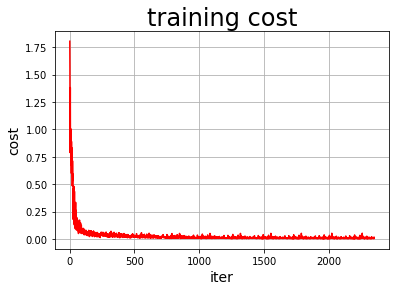

In [53]:
import numpy as np
with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
    model=Regressor('abalone')
    optimizer=fluid.optimizer.SGD(learning_rate=0.005,parameter_list=model.parameters())

    iter=0
    iters=[]
    train_costs=[]

    for i in range(10):
        model.train()
        for batch_id,data in enumerate(train_reader()):
            #if batch_id>5:break
            test_x=np.array([x[0] for x in data],np.float32)
            test_y=np.array([x[1] for x in data],np.float32)
            features=fluid.dygraph.to_variable(test_x)
            ages=fluid.dygraph.to_variable(test_y)

            predicts=model(features)
            loss=fluid.layers.square_error_cost(predicts,label=ages)
            avg_loss=fluid.layers.mean(loss)

            iter=iter+1
            iters.append(iter)
            train_costs.append(avg_loss.numpy())

            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    draw_train_process(iters,train_costs)

Test 0 cost 0.13377
Test 1 cost 0.08831
Test 2 cost 0.06917
Test 3 cost 0.05877
Test 4 cost 0.05209
Test 5 cost 0.04732
Test 6 cost 0.04367
Test 7 cost 0.04074
Test 8 cost 0.03831
Test 9 cost 0.03625


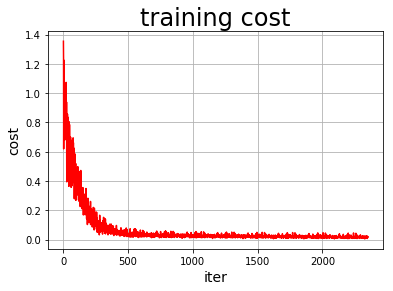

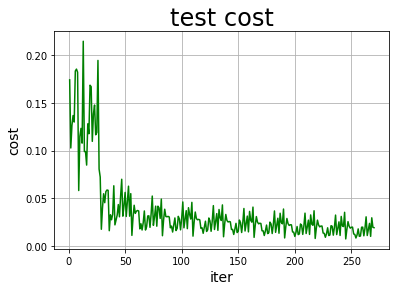

In [67]:
def train():
    iter=0
    iters=[]
    train_costs=[]
    test_iter=0
    test_iters=[]
    test_costs=[]

    with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
        model=Regressor('regress2')
        optimizer=fluid.optimizer.SGD(learning_rate=0.001,parameter_list=model.parameters())

        for i in range(10):
            model.train()
            for batch_id,data in enumerate(train_reader()):

                test_x=np.array([x[0] for x in data],np.float32)
                test_y=np.array([x[1] for x in data],np.float32)
                features=fluid.dygraph.to_variable(test_x)
                ages=fluid.dygraph.to_variable(test_y)

                predicts=model(features)
                loss=fluid.layers.square_error_cost(predicts,label=ages)
                avg_loss=fluid.layers.mean(loss)

                iter=iter+1
                iters.append(iter)
                train_costs.append(avg_loss.numpy())

                avg_loss.backward()
                optimizer.minimize(avg_loss)
                model.clear_gradients()

            model.eval()
            for batch_id,data in enumerate(eval_reader()):

                test_x=np.array([x[0] for x in data],np.float32)
                test_y=np.array([x[1] for x in data],np.float32)
                features=fluid.dygraph.to_variable(test_x)
                ages=fluid.dygraph.to_variable(test_y)

                predicts=model(features)
                loss=fluid.layers.square_error_cost(predicts,label=ages)
                avg_loss=fluid.layers.mean(loss)

                test_iter=test_iter+1
                test_iters.append(test_iter)
                test_costs.append(avg_loss.numpy())

            avg_cost=sum(test_costs)/len(test_costs)
            print('Test %d cost %0.5f'%(i,avg_cost))

        draw_train_process(iters,train_costs)
        draw_train_process(test_iters,test_costs,color='green',title='test cost')

train()

